Project for the IBM course Deep learning and Reinforcement learning:

- Trained a neural network  using Tensorflow to predict diabetes on the Pima Diabetes Dataset.  

- Trained a baseline Random forest and compared the performance with the neural network model.

- Experimented with different neural network architectures (feel free to try yourself) and 

- The most improtant findings are highlighted at the end of the notebook! Dont' miss em!

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)


The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.


In [11]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [123]:
## Import Keras objects for Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
## Load diabetes dataset
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv('./data/diabetes.csv', names=names, header=0)
diabetes_df.head()


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [28]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
72,13,126,90,0,0,43.4,0.583,42,1
31,3,158,76,36,245,31.6,0.851,28,1
368,3,81,86,16,66,27.5,0.306,22,0
60,2,84,0,0,0,0.0,0.304,21,0
184,4,141,74,0,0,27.6,0.244,40,0


In [29]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [30]:
# make sure they are np arrays
X = np.array(X)
y = np.array(y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [32]:
# imbalanced classes
diabetes_df['has_diabetes'].value_counts()

0    500
1    268
Name: has_diabetes, dtype: int64

In [33]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.


### Train a baseline Random Forest model with 200 trees



In [34]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [128]:
# soft prediction - probabilities of having diabetes by majority vote (percent of trees voting yes)
y_preds  = rf_model.predict_proba(X_test)

# hard prediction - probabilities of having diabetes
y_preds_binary = rf_model.predict(X_test)

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_preds_binary)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_preds[:,1])))

accuracy is 0.792
roc-auc is 0.856


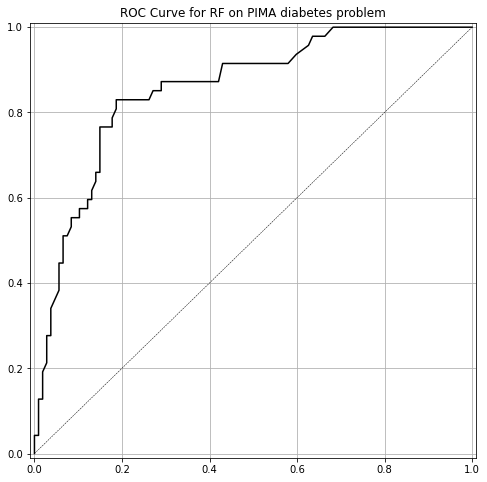

In [122]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred) # False Postive Rate, True Positive Rate, Th
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5) 
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

In [129]:
confusion_matrix(y_test,y_preds_binary)

array([[92, 15],
       [17, 30]], dtype=int64)

Random forest does much better than a random guess with 85% roc-auc and accuracy close to 80%. However a model by just predicting that someone does not have diabetes will get 65% accuracy!

## Train a neural network


Further splitting of the training set into train and validation

In [52]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

Since we neural networks are all about dot products it is best practice to scale the data first.

Random Forest does not need scaling as we only care about splitting the data to leafs based on information gain or impurity (entropy or gini) which is robust to data being in different units of measure.

In [53]:
scaler      = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_val_scaled    = scaler.transform(X_val)
X_test_scaled   = scaler.transform(X_test)

### Tensorflow implementation: building the Neural network structure

In [131]:
ann = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),    
        Dense(25, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'output')
    ], name = "ann" 
)         

In [110]:
ann.summary()

Model: "ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                225       
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [111]:
ann.compile(
    loss     = tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

history = ann.fit(
    X_train2_scaled,y_train2,
    epochs=200,
    validation_data=(X_val_scaled, y_val)
)

Epoch 1/200
16/16 [==============================] - 1s 14ms/step - loss: 0.6445 - accuracy: 0.6558 - val_loss: 0.6413 - val_accuracy: 0.6260
Epoch 2/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.6497 - val_loss: 0.6272 - val_accuracy: 0.6341
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6132 - accuracy: 0.6436 - val_loss: 0.6164 - val_accuracy: 0.6341
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6030 - accuracy: 0.6456 - val_loss: 0.6075 - val_accuracy: 0.6341
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 0.5938 - accuracy: 0.6517 - val_loss: 0.5988 - val_accuracy: 0.6504
Epoch 6/200
16/16 [==============================] - 0s 5ms/step - loss: 0.5854 - accuracy: 0.6640 - val_loss: 0.5907 - val_accuracy: 0.6423
Epoch 7/200
16/16 [==============================] - 0s 5ms/step - loss: 0.5772 - accuracy: 0.6721 - val_loss: 0.5828 - val_accuracy: 0.6748
Epoch 8/200


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


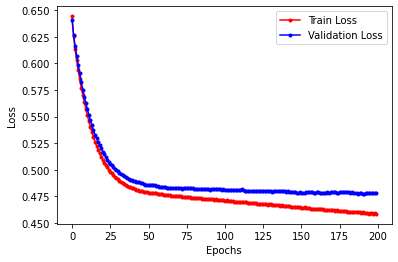

In [112]:
# Check the available keys in the history
print(history.history.keys())

# Create a plot with train and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"], 'r', marker='.', label="Train Loss")
ax.plot(history.history["val_loss"], 'b', marker='.', label="Validation Loss")

# Add labels and legend
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Show the plot
plt.show()

#### Training Loss keeps decreasing but slowsdown around 200 epochs. The differences are very small. Validation loss stops decreasing. Model doesnt look to benefit more with further training.

### Predictions on the test set

In [103]:
# soft prediction - probabilities of having diabetes

y_preds = ann.predict(X_test_scaled)

5/5 [==============================] - 0s 2ms/step


In [104]:
# hard prediction - 1:have diabetes or 0: does not have
y_preds_binary = np.where(y_preds >= 0.5, 1, 0)

# Plot ROC-AUC curve

accuracy is 0.818
roc-auc is 0.881


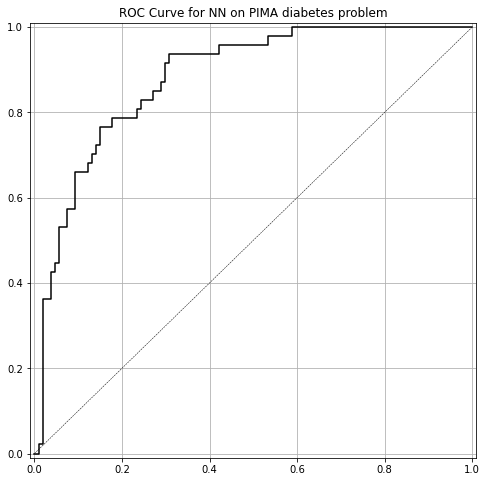

In [105]:

print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_preds_binary)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_preds )))

plot_roc(y_test, y_preds , 'NN')

Looks like the single layer neural network outperformed the baseline random forest model with a larger roc-auc


Experimenting with different network structures: learning rates, activation functions, gradient descent optiomisation algorithms, numbers of epochs 


In [118]:
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.models import Sequential

ann2 = Sequential([
    Dense(25, input_shape=(8,), activation="relu"),
    Dense(12, activation="relu"),
    Dense(6),  # Remove activation from this Dense layer
    LeakyReLU(alpha=0.3),  # Add a separate LeakyReLU layer after the Dense layer
    Dense(1, activation="sigmoid")
                ])
ann2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"]) #
history = ann2.fit(X_train2_scaled, y_train2, validation_data=(X_val_scaled ,y_val), epochs=1500)
y_preds    = ann2.predict(X_test_scaled)
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_preds_binary)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_preds )))

Epoch 1/1500
16/16 [==============================] - 1s 15ms/step - loss: 0.6788 - accuracy: 0.6110 - val_loss: 0.6522 - val_accuracy: 0.6748
Epoch 2/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.6766 - accuracy: 0.6253 - val_loss: 0.6502 - val_accuracy: 0.6992
Epoch 3/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.6375 - val_loss: 0.6484 - val_accuracy: 0.7073
Epoch 4/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.6477 - val_loss: 0.6465 - val_accuracy: 0.7073
Epoch 5/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.6704 - accuracy: 0.6721 - val_loss: 0.6447 - val_accuracy: 0.7154
Epoch 6/1500
16/16 [==============================] - 0s 8ms/step - loss: 0.6684 - accuracy: 0.6741 - val_loss: 0.6428 - val_accuracy: 0.7317
Epoch 7/1500
16/16 [==============================] - 0s 5ms/step - loss: 0.6664 - accuracy: 0.6741 - val_loss: 0.6410 - val_accuracy: 0.7398
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


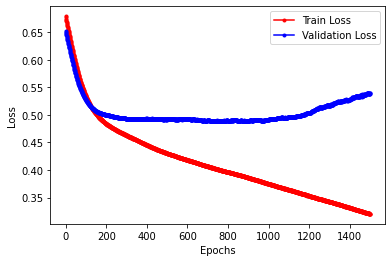

In [119]:
# Check the available keys in the history
print(history.history.keys())

# Create a plot with train and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"], 'r', marker='.', label="Train Loss")
ax.plot(history.history["val_loss"], 'b', marker='.', label="Validation Loss")

# Add labels and legend
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Show the plot
plt.show()

Validation and Training loss keep decreasing until around 1000-1200 epochs were the validation loss starts increasing. That means the model starts to overfit the data. To mitigate overfitting we can consider **EarlyStopping**

### Conclusion: 

 I expiremented with adding more layers to the architecture to increase complexity but it looks like there is no benefit by just adding layers. The dataset is small and increasing the number of parameters does not help. 
 
 The fact that the model performs similarly with 1 hidden layer with 25 units and with 3 hidden layers with 25, 12, and 6 units suggests that the simpler architecture is sufficient to capture the underlying patterns in your dataset. 
 
 Different activation functions, optimizations and epochs were considered did not see much improvement in the performance if any at all.

<sub> This is a projet I did for the IBM DeepLearning and Reinforcement Learning course </sub>

<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>
